# Pulse schedules

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.4.0
qiskit-ibm-runtime~=0.36.1
```
</details>

<Admonition type="danger" title='Removal of Pulse Support'>

With the introduction of [fractional gates](/guides/fractional-gates), pulse-level control on all IBM Quantum&reg; processors has been removed.

Additionally, the `qiskit.pulse` module has been **removed** as of the Qiskit SDK v2.0.0 (but is still supported under the Qiskit SDK v1.4 until September of 2025). See the [migration guide](../migration-guides/pulse-migration) for more information.

</Admonition>

## Overview

Most quantum algorithms can be described with circuit operations alone. When you need more control over the low-level program implementation, you can use _pulse gates_. Pulse gates remove the constraint of executing circuits with basis gates only and let you override the default implementation of any basis gate.

Pulse gates let you map a logical circuit gate (for example, `X`) to a Qiskit Pulse program, called a `ScheduleBlock`. This mapping is referred to as a _calibration_. A high-fidelity calibration is one that faithfully implements the logical operation it is mapped from (for example, whether the `X` gate calibration drives $|0\rangle$ to $|1\rangle$).

A schedule specifies the exact time dynamics of the input signals across all input _channels_ to the device. There are usually multiple channels per qubit, such as drive and measure. This interface is more powerful, and requires a deeper understanding of the underlying device physics.

It's important to note that pulse programs operate on physical qubits. A drive pulse on qubit $a$ does not enact the same logical operation on the state of qubit $b$.  In other words, gate calibrations are not interchangeable across qubits. This is in contrast to the circuit level, where an `X` gate is defined independently of its qubit operand.

This page shows you how to add a calibration to your circuit.

**Note:** Not all QPUs support pulse gates. To see which QPUs have pulse gate support, filter your view (click the funnel icon) on the [Compute resources page](https://quantum.ibm.com/services/resources) by checking the _Pulse gates_ box.

### Build your circuit

Let's start with a very simple example, a Bell state circuit.

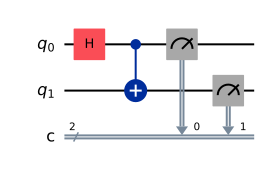

In [1]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)

circ.draw("mpl")

### Build your calibrations

Define a calibration for the Hadamard gate on qubit 0.

In practice, the pulse shape and its parameters would be optimized through a series of calibration experiments. For this demonstration, the Hadamard will be a Gaussian pulse. You _play_ the pulse on the _drive_ channel of qubit 0.

For more information about calibrations, see the [legacy Qiskit Experiments tutorial in GitHub.](https://github.com/qiskit-community/qiskit-experiments/blob/stable/0.8/docs/tutorials/calibrations.rst)

In [2]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit_ibm_runtime.fake_provider import FakeValenciaV2

backend = FakeValenciaV2()

with pulse.build(backend, name="hadamard") as h_q0:
    pulse.play(
        Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0)
    )

/tmp/ipykernel_5320/889520912.py:7: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="hadamard") as h_q0:


/tmp/ipykernel_5320/889520912.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0)
/tmp/ipykernel_5320/889520912.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(


Let's draw the new schedule to see what we've built.

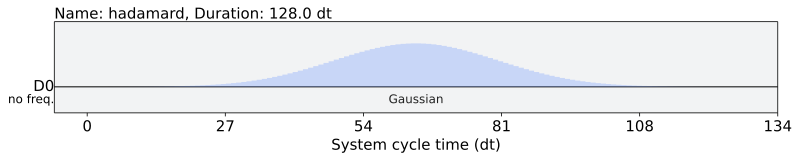

In [3]:
h_q0.draw()

### Link your calibration to your circuit

All that remains is to complete the registration. The circuit method `add_calibration` needs information about the gate and a reference to the schedule to complete the mapping:

`QuantumCircuit.add_calibration(gate, qubits, schedule, parameters)`

The `gate` can be either a `circuit.Gate` object or the name of the gate. Usually, you'll need a different schedule for each unique set of `qubits` and `parameters`. Since the Hadamard gate doesn't have any parameters, there is no need to supply any.

In [4]:
circ.add_calibration("h", [0], h_q0)

/tmp/ipykernel_5320/1015678639.py:1: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` will have no alternative in Qiskit.
  circ.add_calibration("h", [0], h_q0)


Lastly, note that the transpiler will respect your calibrations. Use it as you normally would (our example is too simple for the transpiler to optimize, so the output is the same).

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]) (0, 1)
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]) (1, 0)
Instruction(name='id', num_qubits=1, num_clbits=0, params=[]) (0,)
Instruction(name='id', num_qubits=1, num_clbits=0, params=[]) (1,)
Delay(duration=t[unit=dt]) (0,)
Delay(duration=t[unit=dt]) (1,)
Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]) (0,)
Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]) (1,)
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]) (0,)
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]) (1,)
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) (0,)
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) (1,)
Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]) (0,)
Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]) (1,)
Instruction(name='x', num_qubits=1, num_clbits=0, params=[]) (0,)
Instruction(name='x', 

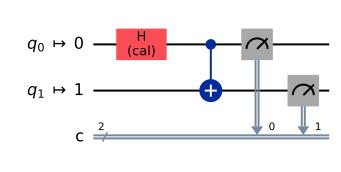

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeHanoiV2
from qiskit.transpiler import generate_preset_pass_manager

backend = FakeHanoiV2()
passmanager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
circ = passmanager.run(circ)

# Print instructions that only affect qubits 0 and 1
for instruction, qubits in FakeHanoiV2().instructions:
    if qubits and set(qubits).issubset({0, 1}):
        print(instruction, qubits)
circ.draw("mpl", idle_wires=False)

Notice that `h` is not a basis gate for the mock backend `FakeHanoiV2`. Since you added a calibration for it, the transpiler will treat the gate as a basis gate, _but only on the qubits for which it was defined_. A Hadamard applied to a different qubit would be unrolled to the basis gates.

### Custom gates

This demonstrates the same process for nonstandard, completely custom gates, including a gate with parameters.

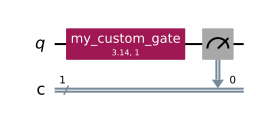

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
custom_gate = Gate("my_custom_gate", 1, [3.14, 1])
# 3.14 is an arbitrary parameter for demonstration
circ.append(custom_gate, [0])
circ.measure(0, 0)

circ.draw("mpl")

In [7]:
with pulse.build(backend, name="custom") as my_schedule:
    pulse.play(
        Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0)
    )

circ.add_calibration("my_custom_gate", [0], my_schedule, [3.14, 1])
# Alternatively: circ.add_calibration(custom_gate, [0], my_schedule)

/tmp/ipykernel_5320/1758347651.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="custom") as my_schedule:
/tmp/ipykernel_5320/1758347651.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0)
/tmp/ipykernel_5320/1758347651.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprec

If you use the `Gate` instance variable `custom_gate` to add the calibration, the parameters are derived from that instance. Remember that the order of parameters is significant.

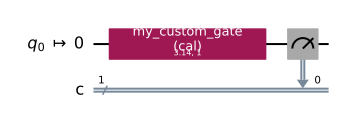

In [8]:
circ = passmanager.run(circ)
circ.draw("mpl", idle_wires=False)

Normally, if you tried to transpile `circ`, you would get an error. There was no functional definition provided for `"my_custom_gate"`, so the transpiler can't unroll it to the basis gate set of the target device. You can show this by trying to add `"my_custom_gate"` to another qubit that hasn't been calibrated.

In [9]:
from qiskit import QiskitError

circ = QuantumCircuit(2, 2)
circ.append(custom_gate, [1])

try:
    circ = passmanager.run(circ)
except QiskitError as e:
    print(e)

"HighLevelSynthesis was unable to synthesize Instruction(name='my_custom_gate', num_qubits=1, num_clbits=0, params=[3.14, 1])."


To link a custom gate to your circuits, you can also add to `Target` and transpile. A pass manager pass implicitly extracts calibration data from the target and calls `add_calibration`. This is convenient if you need to attach a calibration to multiple circuits or manage multiple calibrations.

In [10]:
from qiskit_ibm_runtime.fake_provider import FakeKyoto
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties

backend = FakeKyoto()

custom_gate = Gate("my_gate", 1, [])
qc = QuantumCircuit(1, 1)
qc.append(custom_gate, [0])
qc.measure(0, 0)

with builder.build() as custom_sched_q0:
    builder.play([0.1] * 160, DriveChannel(0))

backend.target.add_instruction(
    custom_gate,
    {(0,): InstructionProperties(calibration=custom_sched_q0)},
)

# Re-generate the passmanager with the new backend target
passmanager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
qc = passmanager.run(qc)

/tmp/ipykernel_5320/2463145812.py:13: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with builder.build() as custom_sched_q0:
/tmp/ipykernel_5320/2463145812.py:14: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  builder.play([0.1] * 160, DriveChannel(0))
/tmp/ipykernel_5320/2463145812.py:14: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamic

/tmp/ipykernel_5320/2463145812.py:18: DeprecationWarning: ``qiskit.transpiler.target.InstructionProperties.__init__()``'s argument ``calibration`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and this argument uses a dependency on the package.
  {(0,): InstructionProperties(calibration=custom_sched_q0)},


## Build pulse schedules

Pulse gates define a low-level, exact representation for a circuit gate. A single operation can be implemented with a pulse program, which is comprised of multiple low-level instructions.  Regardless of how the program is used, the syntax for building the program is the same.

**Important:** For IBM&reg; devices, pulse programs are used as subroutines to describe gates. IBM devices do not accept full programs in this format.

A pulse program, which is called a `ScheduleBlock`, describes instruction sequences for the control electronics. Use the Pulse Builder to build a `ScheduleBlock`, then initialize a schedule:

In [11]:
from qiskit import pulse

with pulse.build(name="my_example") as my_program:
    # Add instructions here
    pass

my_program

/tmp/ipykernel_5320/1973151745.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="my_example") as my_program:


ScheduleBlock(, name="my_example", transform=AlignLeft())

You can see that there are no instructions yet. The next section explains each of the instructions you might add to a schedule, and the last section will describe various _alignment contexts_, which determine how instructions are placed in time relative to one another.

### `ScheduleBlock` Instructions

 - [delay(duration, channel)](#delay)
 - [play(pulse, channel)](#play)
 - [set_frequency(frequency, channel)](#set_frequency)
 - [shift_phase(phase, channel)](#shift_phase)
 - [shift_frequency(frequency, channel)](#shift_frequency)
 - [set_phase(phase, channel)](#set_phase)
 - [acquire(duration, channel, mem_slot, reg_slot)](#acquire)

Each instruction type has its own set of operands. As you can see above, they each include at least one `Channel` to specify where the instruction will be applied.

**Channels** are labels for signal lines from the control hardware to the quantum chip.

 - A `DriveChannel` is typically used for _driving_ single-qubit rotations.
 - A `ControlChannel` is typically used for multi-qubit gates or additional drive lines for tunable qubits.
 - A `MeasureChannel` is specific to transmitting pulses that stimulate readout.
 - An `AcquireChannel` is used to trigger digitizers which collect readout signals.

`DriveChannel`s, `ControlChannel`s, and `MeasureChannel`s are all `PulseChannel`s; this means that they support _transmitting_ pulses, whereas the `AcquireChannel` is a receive channel only and cannot play waveforms.

In the following examples, you can create one `DriveChannel` instance for each `Instruction` that accepts a `PulseChannel`. Channels take one integer `index` argument. Except for `ControlChannel`s, the index maps trivially to the qubit label.

In [12]:
from qiskit.pulse import DriveChannel

channel = DriveChannel(0)

/tmp/ipykernel_5320/501434037.py:3: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  channel = DriveChannel(0)


The pulse `ScheduleBlock` is independent of the backend it runs on. However, you can build your program in a context that is aware of the target backend by supplying it to `pulse.build`. When possible you should supply a backend. By using the channel accessors `pulse.<type>_channel(<idx>)` you ensure you are only using available device resources.

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeValenciaV2

backend = FakeValenciaV2()

with pulse.build(
    backend=backend, name="backend_aware"
) as backend_aware_program:
    channel = pulse.drive_channel(0)
    print(pulse.num_qubits())
    # Raises an error as backend only has 5 qubits
    # pulse.drive_channel(100)

5


/tmp/ipykernel_5320/3624911394.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(
/tmp/ipykernel_5320/3624911394.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  channel = pulse.drive_channel(0)
/tmp/ipykernel_5320/3624911394.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.num_qubits()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https:

### `delay`

One of the simplest instructions is `delay`. This is a blocking instruction that tells the control electronics to output no signal on the given channel for the duration specified. It is useful for controlling the timing of other instructions.

The duration here and elsewhere is in terms of the backend's cycle time (1 / sample rate), `dt`. It must take an integer value.

To add a `delay` instruction, pass a duration and a channel, where `channel` can be any kind of channel, including `AcquireChannel`. Use `pulse.build` to begin a Pulse Builder context. This automatically schedules the delay into the schedule `delay_5dt`.

In [14]:
with pulse.build(backend) as delay_5dt:
    pulse.delay(5, channel)

/tmp/ipykernel_5320/1337470939.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend) as delay_5dt:
/tmp/ipykernel_5320/1337470939.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.delay()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.delay(5, channel)


Any instruction added after this delay on the same channel will execute five timesteps later than it would have without this delay.

### `play`

The `play` instruction is responsible for executing _pulses_. It's straightforward to add a play instruction:

```
with pulse.build() as sched:
    pulse.play(pulse, channel)
```

Let's clarify what the `pulse` argument is and explore a few different ways to build one.

#### Pulses

A `Pulse` specifies an arbitrary pulse _envelope_. The modulation frequency and phase of the output waveform are controlled by the [`set_frequency`](#set_frequency) and [`shift_phase`](#shift_phase) instructions.

There are many methods available for building pulses, such as those available in the Qiskit Pulse `library`.  Take for example a simple Gaussian pulse -- a pulse with its envelope described by a sampled Gaussian function. We arbitrarily choose an amplitude of 1, standard deviation $\sigma$ of 10, and 128 sample points.

**Note**: The amplitude norm is arbitrarily limited to `1.0`. Each backend may also impose further constraints.  For instance, a minimum pulse size of 64. Any additional constraints are provided through [Target.](../api/qiskit/qiskit.transpiler.Target)

In [15]:
from qiskit.pulse import library

amp = 1
sigma = 10
num_samples = 128

##### Parametric pulses
You can build a Gaussian pulse by using the `Gaussian` parametric pulse. A parametric pulse sends the name of the function and its parameters to the backend, rather than every individual sample. Using parametric pulses makes the jobs much smaller to send. IBM Quantum backends limit the maximum job size that they accept, so parametric pulses might allow you to run larger programs.

Other parametric pulses in the `library` include `GaussianSquare`, `Drag`, and `Constant`. See the [full list in the API reference](/api/qiskit/1.4/pulse#parametric-pulse-representation).


**Note**: The backend is responsible for deciding how to sample the parametric pulses. It is possible to draw parametric pulses, but the samples displayed are not guaranteed to be the same as those executed on the backend.

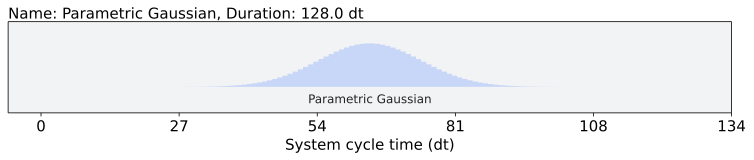

In [16]:
gaussian = pulse.library.Gaussian(
    num_samples, amp, sigma, name="Parametric Gaussian"
)
gaussian.draw()

##### Pulse waveforms described by samples

A `Waveform` is a pulse signal specified as an array of time-ordered complex amplitudes, or _samples_. Each sample is played for one cycle, a timestep `dt`, determined by the backend. You must know the value of `dt` to determine a program's real-time dynamics. The (zero-indexed) $i^{th}$ sample plays from time `i*dt` up to `(i + 1)*dt`, modulated by the qubit frequency.

/tmp/ipykernel_5320/1496865686.py:8: DeprecationWarning: The class ``qiskit.pulse.library.waveform.Waveform`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  gaussian = library.Waveform(gaussian_samples, name="WF Gaussian")


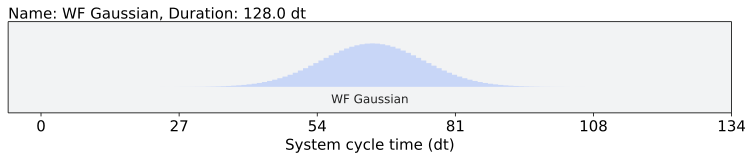

In [17]:
import numpy as np

times = np.arange(num_samples)
gaussian_samples = np.exp(
    -1 / 2 * ((times - num_samples / 2) ** 2 / sigma**2)
)

gaussian = library.Waveform(gaussian_samples, name="WF Gaussian")
gaussian.draw()

Regardless of which method you use to specify your `pulse`, `play` is added to your schedule the same way:

/tmp/ipykernel_5320/1983464279.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build() as schedule:
/tmp/ipykernel_5320/1983464279.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(gaussian, channel)


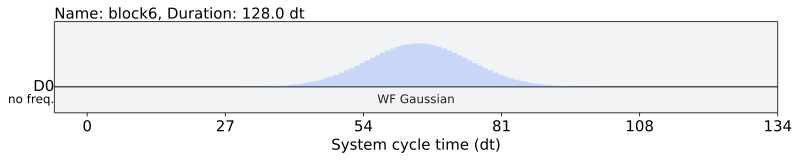

In [18]:
with pulse.build() as schedule:
    pulse.play(gaussian, channel)
schedule.draw()

You may also supply a complex list or array directly to `play`.

/tmp/ipykernel_5320/165485598.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build() as schedule:
/tmp/ipykernel_5320/165485598.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play([0.001 * i for i in range(160)], channel)


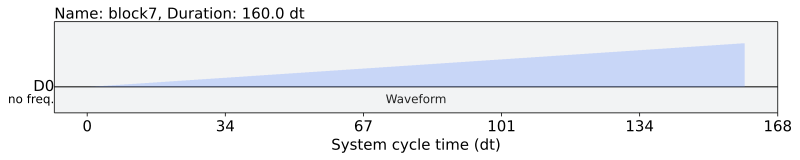

In [19]:
with pulse.build() as schedule:
    pulse.play([0.001 * i for i in range(160)], channel)
schedule.draw()

The `play` instruction gets its duration from its `Pulse`: the duration of a parametrized pulse is an explicit argument, and the duration of a `Waveform` is the number of input samples.

### `set_frequency`

As explained previously, the output pulse waveform envelope is also modulated by a frequency and phase. Each channel has a default frequency listed in the `backend.defaults`.

A channel's frequency can be updated at any time within a `ScheduleBlock` by the `set_frequency` instruction. It takes a float `frequency` and a `PulseChannel` `channel` as input. All pulses on a channel following a `set_frequency` instruction are modulated by the given frequency until another `set_frequency` instruction is encountered or until the program ends.

The instruction has an implicit duration of `0`.

**Note**: The frequencies that can be requested are limited by the total bandwidth and the instantaneous bandwidth of each hardware channel. In the future, these will be reported by the `backend`.

In [20]:
with pulse.build(backend) as schedule:
    pulse.set_frequency(4.5e9, channel)

/tmp/ipykernel_5320/3276186557.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend) as schedule:
/tmp/ipykernel_5320/3276186557.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(4.5e9, channel)


### `shift_frequency`

The `shift_frequency` instruction shifts the `frequency` of a pulse `channel`.

In [21]:
d0 = pulse.DriveChannel(0)

with pulse.build() as pulse_prog:
    pulse.shift_frequency(1e9, d0)

/tmp/ipykernel_5320/327681344.py:1: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  d0 = pulse.DriveChannel(0)
/tmp/ipykernel_5320/327681344.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build() as pulse_prog:
/tmp/ipykernel_5320/327681344.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.shift_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: http

<Admonition type="note" title="Note">
The `shift_frequency` and `set_frequency` instructions change the frequency of following pulses and also change the channel's frame of reference. Because a qubit oscillates at its transition frequency, the controller needs to sync with its oscillation; otherwise, an unwanted Z drive is continuously applied. Usually, because the frame is matched with the drive's frequency, and drive matches with the transition's frequency, the Z drive is eliminated when the qubit frequency is calibrated properly. When you apply the `shift_frequency` instruction, it changes the drive frequency and impacts the frame. In other words, it accumulates the phase (Z) as a function of shifted frequency and duration of the program. Specifically, when you shift the frequency by `df` and spend `dt` on that frame, the qubit may experience a phase rotation of `df * dt`. The programmer needs to take this into account to control their qubits precisely.

Note also that these instructions are localized in the pulse gate in IBM devices. This means that accumulated phase and frequency shifts are not carried over. Each pulse gate always starts from the hardware default setting. This behavior is backend-dependent.
</Admonition>

### `set_phase`

The `set_phase` instruction sets the phase of a pulse channel.

In [22]:
d0 = pulse.DriveChannel(0)

with pulse.build() as pulse_prog:
    pulse.set_phase(np.pi, d0)

/tmp/ipykernel_5320/4030167415.py:1: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  d0 = pulse.DriveChannel(0)
/tmp/ipykernel_5320/4030167415.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build() as pulse_prog:
/tmp/ipykernel_5320/4030167415.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_phase()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https:/

### `shift_phase`

The `shift_phase` instruction will increase the phase of the frequency modulation by `phase`. Like `set_frequency`, this phase shift will affect all following instructions on the same channel until the program ends. To undo the affect of a `shift_phase`, the negative `phase` can be passed to a new instruction.

Like `set_frequency`, the instruction has an implicit duration of `0`.

In [23]:
with pulse.build(backend) as schedule:
    pulse.shift_phase(np.pi, channel)

/tmp/ipykernel_5320/2840692844.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend) as schedule:
/tmp/ipykernel_5320/2840692844.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.shift_phase()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.shift_phase(np.pi, channel)


### `acquire`

The `acquire` instruction triggers data acquisition for readout. It takes a duration, an `AcquireChannel`, which maps to the qubit being measured, and a `MemorySlot` or a `RegisterSlot`. The `MemorySlot` is classical memory where the readout result will be stored. The `RegisterSlot` maps to a register in the control electronics that stores the readout result for fast feedback.

The `acquire` instruction can also take custom `Discriminator`s and `Kernel`s as keyword arguments. The `Kernel` subroutine integrates a time series of measurement responses and generates an IQ data point, which will be classified into a quantum state by the discriminator. This indicates that if you use a custom measurement stimulus, as in a measurement pulse, you might need to update the kernel setting to not deteriorate the measurement SNR.

In [24]:
from qiskit.pulse import MemorySlot

with pulse.build(backend) as schedule:
    pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))

/tmp/ipykernel_5320/988163519.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend) as schedule:
/tmp/ipykernel_5320/988163519.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.acquire_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))
/tmp/ipykernel_5320/988163519.py:4: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved 

After adding `ScheduleBlock` instructions, you need to understand how to control when they're played.

## Pulse Builder
Below are the most important Pulse Builder features for learning how to build schedules. This is not an exhaustive list.  For more details about using the Pulse Builder, refer to the [Pulse API reference.](/api/qiskit/1.4/pulse)

### Alignment contexts
The builder has alignment contexts that influence how a schedule is built. Contexts can also be nested. Try them out, and use `.draw()` to see how the pulses are aligned.

Regardless of the alignment context, the duration of the resulting schedule is as short as it can be while including every instruction and following the alignment rules. This still allows some degrees of freedom for scheduling instructions off the "longest path". The examples below illustrate this.

### `align_left`
The builder has alignment contexts that influence how a schedule is built. The default is `align_left`.

/tmp/ipykernel_5320/1095120153.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="Left align example") as program:
/tmp/ipykernel_5320/1095120153.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(gaussian_pulse, pulse.drive_channel(0))
/tmp/ipykernel_5320/1095120153.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated 

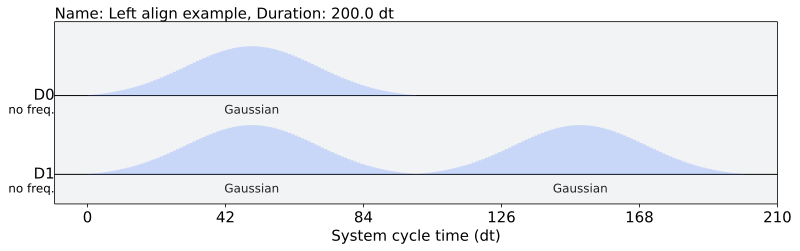

In [25]:
with pulse.build(backend, name="Left align example") as program:
    with pulse.align_left():
        gaussian_pulse = library.Gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

Notice how there is no scheduling freedom for the pulses on `D1`. The second waveform begins immediately after the first. The pulse on `D0` can start at any time between `t=0` and `t=100` without changing the duration of the overall schedule. The `align_left` context sets the start time of this pulse to `t=0`. You can think of this like left-justification of a text document.


### `align_right`
`align_right` does the opposite of `align_left`. It chooses `t=100` in the above example to begin the Gaussian pulse on `D0`. Left and right are also sometimes called "as soon as possible" and "as late as possible" scheduling, respectively.

/tmp/ipykernel_5320/624025647.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="Right align example") as program:
/tmp/ipykernel_5320/624025647.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(gaussian_pulse, pulse.drive_channel(0))
/tmp/ipykernel_5320/624025647.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated an

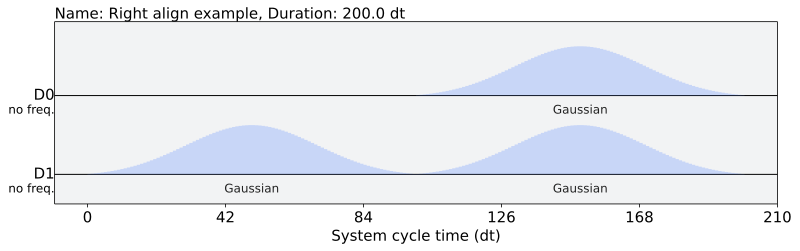

In [26]:
with pulse.build(backend, name="Right align example") as program:
    with pulse.align_right():
        gaussian_pulse = library.Gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

### `align_equispaced(duration)`

If the duration of a particular block is known, you can also use `align_equispaced` to insert equal duration delays between each instruction.

/tmp/ipykernel_5320/1975630487.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="example") as program:
/tmp/ipykernel_5320/1975630487.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(gaussian_pulse, pulse.drive_channel(0))
/tmp/ipykernel_5320/1975630487.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be

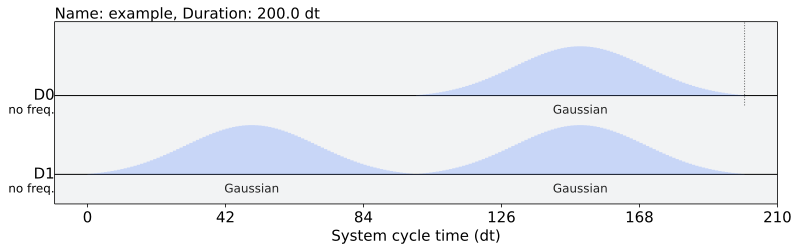

In [27]:
with pulse.build(backend, name="example") as program:
    gaussian_pulse = library.Gaussian(100, 0.5, 20)
    with pulse.align_equispaced(2 * gaussian_pulse.duration):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

### `align_sequential`

This alignment context does not schedule instructions in parallel. Each instruction will begin at the end of the previously added instruction.

/tmp/ipykernel_5320/1927066405.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="example") as program:
/tmp/ipykernel_5320/1927066405.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.play(gaussian_pulse, pulse.drive_channel(0))
/tmp/ipykernel_5320/1927066405.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be

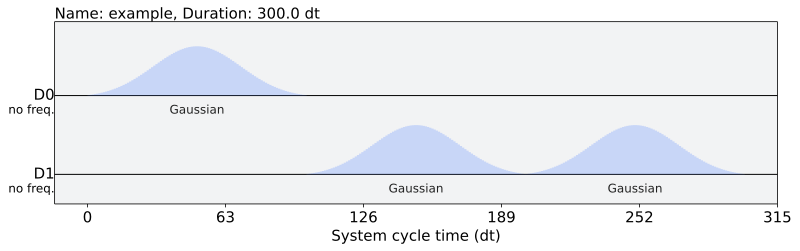

In [28]:
with pulse.build(backend, name="example") as program:
    with pulse.align_sequential():
        gaussian_pulse = library.Gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

### Phase and frequency offsets

The builder can help temporarily offset the frequency or phase of pulses on a channel.

/tmp/ipykernel_5320/869399433.py:1: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend, name="Offset example") as program:
/tmp/ipykernel_5320/869399433.py:2: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.phase_offset(3.14, pulse.drive_channel(0)):
/tmp/ipykernel_5320/869399433.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.drive_channel()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being depre

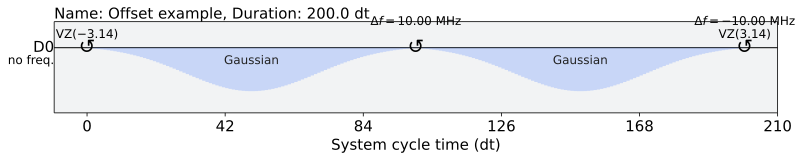

In [29]:
with pulse.build(backend, name="Offset example") as program:
    with pulse.phase_offset(3.14, pulse.drive_channel(0)):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        with pulse.frequency_offset(10e6, pulse.drive_channel(0)):
            pulse.play(gaussian_pulse, pulse.drive_channel(0))

program.draw()

## Next steps

<Admonition type="tip" title="Recommendations">

- Review the [Pulse API](/api/qiskit/1.4/pulse) reference.
- See the [Qiskit Experiments](https://qiskit.org/ecosystem/experiments/) documentation.
</Admonition>